<a href="https://colab.research.google.com/github/nudumulla2019/Biostatistics-5195/blob/master/Biostatistics_Lab_4_Rice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rice Seed Classification

How will you classify the bellow two images?

![1rice](https://github.com/totti0223/deep_learning_for_biologists_with_keras/raw/master/assets/11.jpg) Proper Shaped Rice Seed

![2rice](https://github.com/totti0223/deep_learning_for_biologists_with_keras/raw/master/assets/141.jpg) Broken Rice Seed



In [1]:
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.transform import resize

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    #code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:
!#we will use the rice seed image datset
!apt-get install subversion > /dev/null
!svn export https://github.com/totti0223/deep_learning_for_biologists_with_keras/trunk/notebooks/data/image image > /dev/null

In [5]:
#this command below see inspects part of the files which have been downloaded from the cell above
!ls image
!ls image/train
!ls image/train/proper

test  test.txt	train  train.txt
broken	proper
100.jpg  117.jpg  132.jpg  15.jpg   22.jpg  39.jpg  56.jpg  73.jpg  90.jpg
101.jpg  118.jpg  133.jpg  16.jpg   23.jpg  40.jpg  57.jpg  74.jpg  91.jpg
102.jpg  119.jpg  134.jpg  17.jpg   24.jpg  41.jpg  58.jpg  75.jpg  92.jpg
103.jpg  11.jpg   135.jpg  181.jpg  25.jpg  42.jpg  59.jpg  76.jpg  93.jpg
104.jpg  120.jpg  136.jpg  183.jpg  26.jpg  43.jpg  60.jpg  77.jpg  94.jpg
105.jpg  121.jpg  137.jpg  187.jpg  27.jpg  44.jpg  61.jpg  78.jpg  95.jpg
106.jpg  122.jpg  138.jpg  188.jpg  28.jpg  45.jpg  62.jpg  79.jpg  96.jpg
107.jpg  123.jpg  139.jpg  18.jpg   29.jpg  46.jpg  63.jpg  80.jpg  97.jpg
108.jpg  124.jpg  13.jpg   190.jpg  30.jpg  47.jpg  64.jpg  81.jpg  98.jpg
109.jpg  125.jpg  140.jpg  192.jpg  31.jpg  48.jpg  65.jpg  82.jpg  99.jpg
110.jpg  126.jpg  143.jpg  193.jpg  32.jpg  49.jpg  66.jpg  83.jpg
111.jpg  127.jpg  148.jpg  197.jpg  33.jpg  50.jpg  67.jpg  84.jpg
112.jpg  128.jpg  149.jpg  198.jpg  34.jpg  51.jpg  68.jpg  85.jpg
113

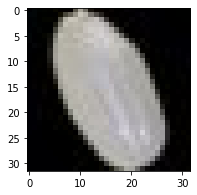

In [6]:
#let's visualize a single file
image = imread("image/train/proper/100.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [7]:
#load training dataset
X_train = []
y_train = []

for root, dirs, files in os.walk("image/train"):
    files = [x for x in files if x.endswith(".jpg")]
    for file in files:
        image_path = os.path.join(root, file)
        
        image = imread(image_path)/255.
        image = resize(image,(28,28))
        X_train.append(image)        
        category = os.path.split(root)[-1]
        if category == "proper":
            y_train.append(0)
        else:
            y_train.append(1)
X_train = np.array(X_train)
y_train = np.array(y_train)



#load test dataset
X_test = []
y_test = []

for root, dirs, files in os.walk("image/test"):
    files = [x for x in files if x.endswith(".jpg")]
    for file in files:
        image_path = os.path.join(root, file)
        
        image = imread(image_path)/255.
        image = resize(image,(28,28))
        X_test.append(image)        
        category = os.path.split(root)[-1]
        if category == "proper":
            y_test.append(0)
        else:
            y_test.append(1)
X_test = np.array(X_test)
y_test = np.array(y_test)

print("train dataset shape is:", X_train.shape,y_train.shape)
print("test dataset shape is:", X_test.shape,y_test.shape)

train dataset shape is: (377, 28, 28, 3) (377,)
test dataset shape is: (20, 28, 28, 3) (20,)


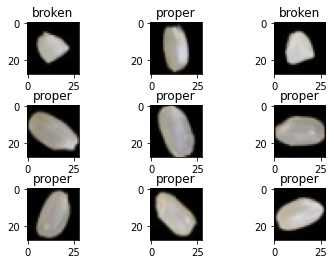

In [8]:
plt.subplots_adjust(wspace=0.4, hspace=0.6)

index = np.random.randint(0,X_train.shape[0],size=9)

for i, idx  in enumerate(index):
    plt.subplot(3,3,i+1)
    
    if y_train[idx] == 0:
        label = "proper"
    else:
        label = "broken"
    plt.title(label)
    plt.imshow(X_train[idx])

(28, 28, 3)


Text(0.5, 1.0, 'original')

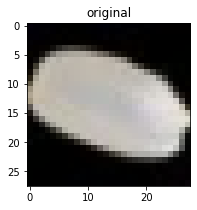

In [9]:
#Let's try it for one image
image = X_train[0]

#the original image
print(image.shape)
plt.figure(figsize=(3,3))
plt.imshow(image)
plt.title("original")

(28, 28)


Text(0.5, 1.0, 'gray converted')

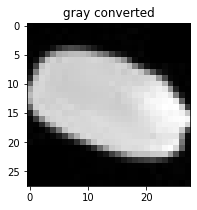

In [10]:
#gray conversion
gray = rgb2gray(image)
print(gray.shape)
plt.figure(figsize=(3,3))
plt.imshow(gray, cmap=plt.cm.gray)
plt.title("gray converted")

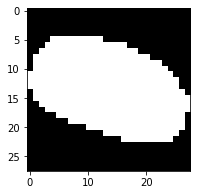

In [11]:
#binary conversion
threshold = threshold_otsu(gray)
binary = gray > threshold
plt.figure(figsize=(3,3))
plt.imshow(binary, cmap=plt.cm.gray)

now that we have a nice binary image, we can isolate the region of rice seed which corresponds to the white region of the image above.

In [12]:
label_im, nb_labels = ndimage.label(binary)
regionprops = measure.regionprops(label_im, intensity_image=gray)
regionprop = regionprops[0]

print("area is",regionprop.area)
print("major axis length is", regionprop.major_axis_length)
print("minor axis length is", regionprop.minor_axis_length)

area is 367
major axis length is 29.276076749487075
minor axis length is 16.024385819463287


In [13]:
#bundling the above into a function
def quantify_area(image):
    gray = rgb2gray(image)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    label_im, nb_labels = ndimage.label(binary)
    regionprops = measure.regionprops(label_im, intensity_image=gray)
    regionprop = regionprops[0]
    area = regionprop.area
    return area

#test
area = quantify_area(image)
print(area)

367


In [14]:
X_train_area = []
for image in X_train:
    area = quantify_area(image)
    X_train_area.append(area)

X_test_area = []
for image in X_test:
    area = quantify_area(image)
    X_test_area.append(area)

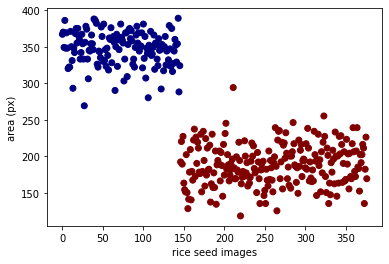

In [15]:
#check the calculated data area value of training dataset
plt.scatter(range(len(X_train_area)),X_train_area,c=y_train,cmap="jet")
plt.xlabel("rice seed images")
plt.ylabel("area (px)")
plt.show()

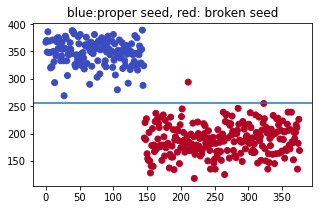

Confusion matrix, without normalization


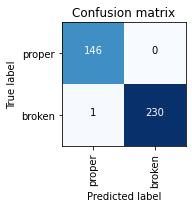

In [16]:
#define an area threshold that can seperate the two classes
#must change from the default value or it won't seperate nicely.
#run this code once and try the suitable value that can seperate blue and red with the horizontal lines
area_threshold = 256


#classify whether the image is a proper seed or a broken seed according to the area_threshold value
train_y_pred = []
for area in X_train_area:
    if area > area_threshold:
        train_y_pred.append(0)
    else:
        train_y_pred.append(1)
        

#plot scatter with threshold line
plt.figure(figsize=(5,3))
plt.scatter(range(len(X_train_area)),X_train_area,c=y_train,cmap=plt.cm.coolwarm)
plt.axhline(y=area_threshold)
plt.title("blue:proper seed, red: broken seed")
plt.show()

#calculate confusion matrix
cnf = confusion_matrix(y_train, train_y_pred)

#confusion matrix in figure
plt.figure(figsize=(3,3))
plot_confusion_matrix(cnf, classes=["proper","broken"])

plt.show()

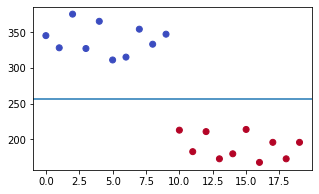

Confusion matrix, without normalization


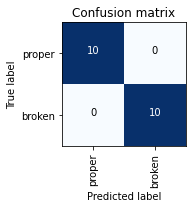

In [17]:
#evaluate it with the test dataset
test_y_pred = []
for area in X_test_area:
    if area > area_threshold:
        test_y_pred.append(0)
    else:
        test_y_pred.append(1)
        
#plot scatter with threshold line
plt.figure(figsize=(5,3))
plt.scatter(range(len(X_test_area)),X_test_area,c=y_test,cmap=plt.cm.coolwarm)
plt.axhline(y=area_threshold)
#plt.plot([100,0],[100,350],'k-',lw=2)
plt.show()

#calculate confusion matrix
cnf = confusion_matrix(y_test, test_y_pred)

#confusion matrix in figure
plt.figure(figsize=(3,3))
plot_confusion_matrix(cnf, classes=["proper","broken"])
plt.show()

correct label is:  1
predicted label is:  1


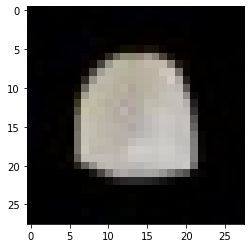

In [18]:
#build a classifier

def manual_classifier(image,area_threshold):
    gray = rgb2gray(image)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    label_im, nb_labels = ndimage.label(binary)
    regionprops = measure.regionprops(label_im, intensity_image=gray)
    regionprop = regionprops[0]
    area = regionprop.area
    if area > area_threshold:
        return 0
    else:
        return 1

# get a image from test dataset #value must be lower than the size of the test dataset(20-1)
n = 10
image = X_test[n]
label = y_test[n]
area_threshold = 350
prediction = manual_classifier(image,area_threshold)

plt.imshow(image)
print("correct label is: ",label)
print("predicted label is: ",prediction)